## Reddit API
- In the following document we will try to extract reddit post:
    - As a first approach we will collect data marked by keyboards relatedt to adhd found in related subreddits
    - To improve our model we can modify our model to identify by it's own (using old data for example) the subreddits that could be intereesting 
    to scrap.


    General composition of a post:
    -  id: The post’s ID
    -  title: The post’s title
    -  text: The post’s text
    -  author: The post’s author
    -  created_utc: The post’s creation time in UTC
    -  score: The post’s score
    -  num_comments: The number of comments on the post
    -  permalink: The post’s permalink

## Connections
#### Connection to the Reddit APi

In [5]:
import os

from dotenv import load_dotenv
import praw

# Load environment variables from .env file
load_dotenv()

try:
    reddit = praw.Reddit(
        client_id=os.getenv("REDDIT_CLIENT_ID"),
        client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
        user_agent=os.getenv("REDDIT_USER_AGENT"),
        username=os.getenv("REDDIT_USERNAME"),
        password=os.getenv("REDDIT_PASSWORD")
    )
    print(f"Connected! Logged in as: {reddit.user.me()}")
except Exception as e:
    print("An error occurred:", e)

Connected! Logged in as: ProfessorMiddle1326


#### Connect to Mongdb

In [34]:
from pymongo import MongoClient

# Load environment variables from .env file
load_dotenv()
mongo='127.0.0.1'

try:
    # Connect to MongoDB
    myclient = MongoClient(
                        "mongodb://"+mongo+":27017/",  
                        username='admin',
                        password='admin') #Mongo URI format
    db=myclient['reddit']
    print("Connected to MongoDB successfully!")
except Exception as e:
    print("An error occurred while connecting to MongoDB:", e)

Connected to MongoDB successfully!


 #### Connect to reddis
 

In [21]:
import redis

r = redis.Redis(host='127.0.0.1', port=6379, db=0)

## Scrap Data Using Research on reddit

#### Scrapp usging the search bar in reddit (search using the keywords):
- Define the keywords for research 
["adhd", "diagnose","energy", "brain", "test", "distracted", "forgetful", "doctor","work","task","disord","struggl","focu","dysfunct","forgot","lazi","prescrib","medic","medicin","pill","self diagnosis","self medication"]
- Different sorting technics ["relevance", "hot", "top", "new", "comments"]


In [ ]:
Querykeywords=["adhd", "diagnose","energy", "brain", "test", "distracted", "forgetful", "doctor"
                  ,"work","task","disord","struggl","focu","dysfunct","forgot","lazi","prescrib","medic","medicin","pill","self diagnosis","self medication"]
sortingTechniques=["relevance", "hot", "top", "new", "comments"]


In [ ]:
import pandas as pd
# Subreddit to target
subreddit_name = "ADHD"
subreddit = reddit.subreddit(subreddit_name)
posts = []

Querykeywords=["self diagnosis","self medication"]

for keyword in Querykeywords:
    for sorting in sortingTechniques:
        print("Searching for keyword:", keyword, "using sorting technique:", sorting)
        for post in subreddit.search(query=keyword,sort=sorting,syntax='cloudsearch',time_filter='all',limit=10000):# 'hot', 'new', or 'top' post    
            datecreated=get_utc_time(post.created_utc)
            year=datecreated.year
            if(year>2019) and (r.sadd('reddit_posts', post.id)):
                posts.append({
                "id":post.id,
                "title": post.title,
                "author": str(post.author),
                "score": post.score,
                "num_comments": post.num_comments,
                "upvote_ratio": post.upvote_ratio,
                "url": post.url,
                "subreddit": post.subreddit.display_name,
                "created_at": post.created_utc,
                "self_text": post.selftext, 
                "searchQuery":keyword,  
            })
        
db.reddit_posts.insert_many(posts)
          
            
    
    



Searching for keyword: self diagnosis using sorting technique: relevance


/tmp/ipykernel_35745/3794372055.py:14: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_time = datetime.datetime.utcfromtimestamp(timestamp)


Searching for keyword: self diagnosis using sorting technique: hot
Searching for keyword: self diagnosis using sorting technique: top
Searching for keyword: self diagnosis using sorting technique: new
Searching for keyword: self diagnosis using sorting technique: comments
Searching for keyword: self medication using sorting technique: relevance
Searching for keyword: self medication using sorting technique: hot
Searching for keyword: self medication using sorting technique: top
Searching for keyword: self medication using sorting technique: new
Searching for keyword: self medication using sorting technique: comments


InsertManyResult([ObjectId('674df915845d7125c2d2c32f'), ObjectId('674df915845d7125c2d2c330'), ObjectId('674df915845d7125c2d2c331'), ObjectId('674df915845d7125c2d2c332'), ObjectId('674df915845d7125c2d2c333'), ObjectId('674df915845d7125c2d2c334'), ObjectId('674df915845d7125c2d2c335'), ObjectId('674df915845d7125c2d2c336'), ObjectId('674df915845d7125c2d2c337'), ObjectId('674df915845d7125c2d2c338'), ObjectId('674df915845d7125c2d2c339'), ObjectId('674df915845d7125c2d2c33a'), ObjectId('674df915845d7125c2d2c33b'), ObjectId('674df915845d7125c2d2c33c'), ObjectId('674df915845d7125c2d2c33d'), ObjectId('674df915845d7125c2d2c33e'), ObjectId('674df915845d7125c2d2c33f'), ObjectId('674df915845d7125c2d2c340'), ObjectId('674df915845d7125c2d2c341'), ObjectId('674df915845d7125c2d2c342'), ObjectId('674df915845d7125c2d2c343'), ObjectId('674df915845d7125c2d2c344'), ObjectId('674df915845d7125c2d2c345'), ObjectId('674df915845d7125c2d2c346'), ObjectId('674df915845d7125c2d2c347'), ObjectId('674df915845d7125c2d2c3

## Analysis of Data Stored

#### First let's define useful functions

In [ ]:
import datetime

def get_year(datetime):
    return datetime.year

def get_utc_time(timestamp):
    # Convert timestamp to UTC datetime
    utc_time = datetime.datetime.utcfromtimestamp(timestamp)
    return utc_time

#### Import data stored in the dataset

In [67]:
#import
posts_registered=[]
query=db.reddit_posts.find({},{'_id':0})
for el in query:
    posts_registered.append(el)
posts_registered_df=pd.DataFrame(posts_registered)
posts_registered_df.head()

,id,title,author,score,num_comments,upvote_ratio,url,subreddit,created_at,self_text,searchQuery
0,1et3kj0,Diagnosed with Inattentive ADHD at 31. Explain...,amadnomad,393,107,0.98,https://www.reddit.com/r/ADHD/comments/1et3kj0...,ADHD,1.723749e+09,Please go out and get tested if you are still ...,adhd
1,1et3kj0,Diagnosed with Inattentive ADHD at 31. Explain...,amadnomad,386,107,0.98,https://www.reddit.com/r/ADHD/comments/1et3kj0...,ADHD,1.723749e+09,Please go out and get tested if you are still ...,adhd
2,1et3kj0,Diagnosed with Inattentive ADHD at 31. Explain...,amadnomad,392,107,0.98,https://www.reddit.com/r/ADHD/comments/1et3kj0...,ADHD,1.723749e+09,Please go out and get tested if you are still ...,adhd
3,1gk5ftv,Children with higher IQ scores were diagnosed ...,Pretend_Voice_3140,4499,466,0.99,https://www.reddit.com/r/ADHD/comments/1gk5ftv...,ADHD,1.730809e+09,A study was published in the [British Journal ...,adhd
4,1f0k9en,Reminder: If you made it to adulthood with lat...,Hipster-Deuxbag,7372,535,0.99,https://www.reddit.com/r/ADHD/comments/1f0k9en...,ADHD,1.724547e+09,"We all know the statistics: 20,000 behavioral ...",adhd


- Some Plots in order to asses the distribution of our dataset

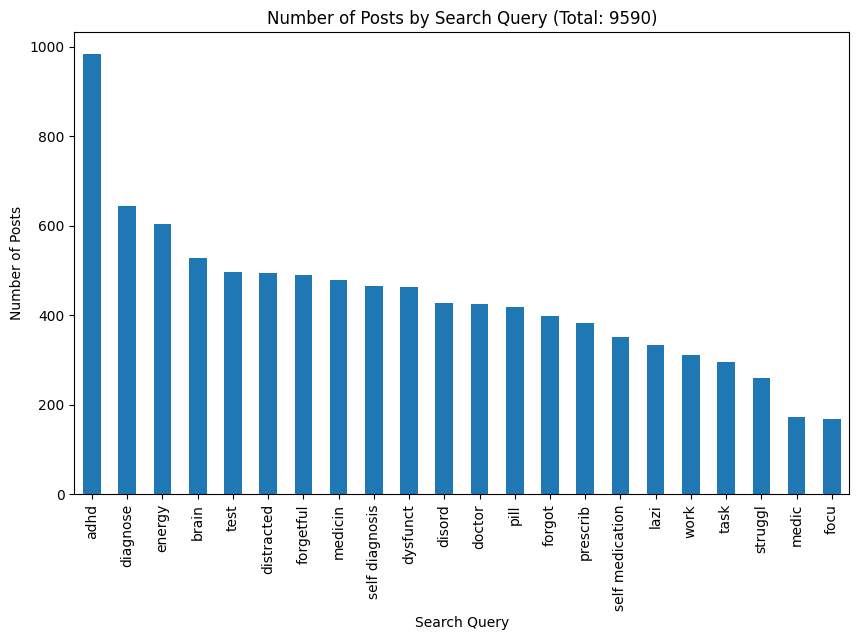

In [ ]:
import matplotlib.pyplot as plt

# Aggregate by a certain column, for example 'searchQuery'
aggregated_data = posts_registered_df['searchQuery'].value_counts()

# Plot the aggregated data
plt.figure(figsize=(10, 6))
aggregated_data.plot(kind='bar')
plt.title('Number of Posts by Search Query (Total: {})'.format(len(posts_registered_df)))
plt.xlabel('Search Query')
plt.ylabel('Number of Posts')
plt.show()


/tmp/ipykernel_35745/3794372055.py:14: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_time = datetime.datetime.utcfromtimestamp(timestamp)


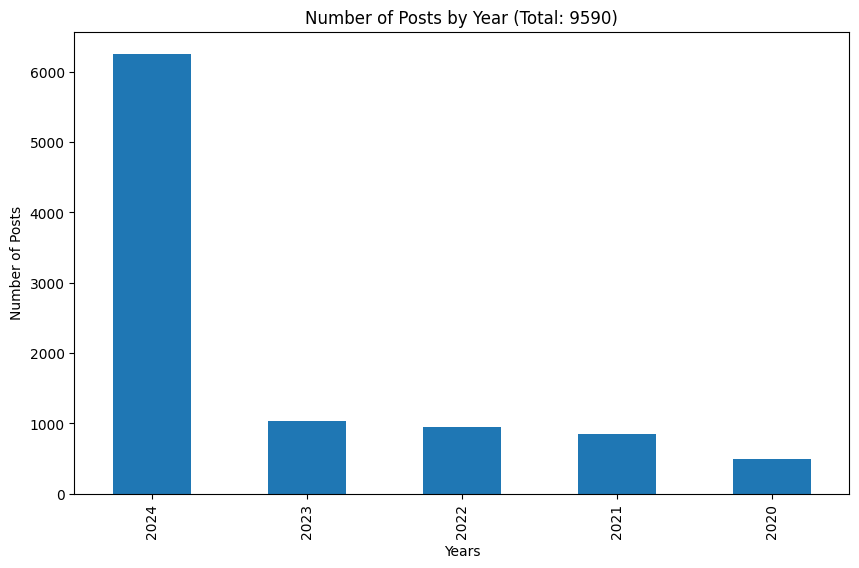

In [ ]:
import matplotlib.pyplot as plt

# Aggregate by a certain column, for example 'searchQuery'
posts_registered_df['created_at']=posts_registered_df['created_at'].apply(get_utc_time)
posts_registered_df['created_year']=posts_registered_df['created_at'].apply(get_year)

aggregated_data = posts_registered_df['created_year'].value_counts()

# Plot the aggregated data
plt.figure(figsize=(10, 6))
aggregated_data.plot(kind='bar')
plt.title('Number of Posts by Year (Total: {})'.format(len(posts_registered_df)))
plt.xlabel('Years')
plt.ylabel('Number of Posts')
plt.show()